# Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import BasicBlock, Bottleneck
from transformers import SamModel, SamProcessor

In [2]:
class Processor:
    def __init__(self):
        self.processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

    def preprocess(self, image):
        inputs = self.processor(image, return_tensors="pt")
        return inputs

    def postprocess(self, inputs, outputs):
        h, w = inputs['original_sizes'][0]

        resized = F.interpolate(
            outputs, size=(h, w),
            mode="bilinear", align_corners=True
        )

        resized = resized.squeeze(1)
        resized *= 255
        return resized


In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.sam = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")
        self.encoder = self.image_encoder
        self.decoder = self.initialize_decoder()

        # Freeze SAM encoder
        for param in self.sam.parameters():
            param.requires_grad = False

    def image_encoder(self, inputs):
        # Extract image embeddings using SAM
        # 256 x 64 x 64
        return self.sam.get_image_embeddings(inputs["pixel_values"])

    def initialize_decoder(self, use_bottleneck=False):
        # Choose block type: BasicBlock or Bottleneck
        Block = Bottleneck if use_bottleneck else BasicBlock

        upscale = nn.Sequential(
            # Upsample 256 x 64 x 64 -> 128 x 128 x 128
            nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2)),
            nn.ReLU(),
            Block(inplanes=128, planes=128),  # Residual Block

            # Upsample 128 x 128 x 128 -> 64 x 256 x 256
            nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2)),
            nn.ReLU(),
            Block(inplanes=64, planes=64),  # Residual Block

            # Reduce channels 64 x 256 x 256 -> 32 x 256 x 256
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            Block(inplanes=32, planes=32),  # Residual Block

            # Final output 32 x 256 x 256 -> 1 x 256 x 256
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        return upscale

    def forward(self, inputs):
        embeddings = self.encoder(inputs)
        depth = self.decoder(embeddings)
        return depth


In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Network().to(device)
processor = Processor()

# Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Dataset
# https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2

# Dataset and DataLoader Reference
# https://www.kaggle.com/code/shreydan/monocular-depth-estimation-nyuv2

Mounted at /content/drive


In [6]:
import os
from pathlib import Path

In [7]:
os.chdir('/content/drive/MyDrive/Depth Estimation')

In [8]:
import pandas as pd

base_path = Path("/content/drive/MyDrive/Depth Estimation/")
train_csv = base_path / Path("data/nyu2_train.csv")

In [84]:
df = pd.read_csv(train_csv, header=None)

# Computational cost is so high ...
df = df.iloc[:5000]

In [85]:
def check_data(file_path):
    for idx in range(len(df)):
        image_path = df.iloc[idx, 0]
        mask_path = df.iloc[idx, 1]

        if not os.path.exists(image_path):
            print(f"Image path does not exist: {image_path}")

        if not os.path.exists(mask_path):
            print(f"Mask path does not exist: {mask_path}")


In [86]:
df[0] = df[0].map(lambda x: base_path / x)
df[1] = df[1].map(lambda x: base_path / x)

In [87]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df,test_size=0.1,shuffle=False)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=False)

train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
len(train_df),len(val_df), len(test_df)

(4500, 450, 50)

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None: d_min = np.min(depth)
    if d_max is None: d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])

    return img_merge

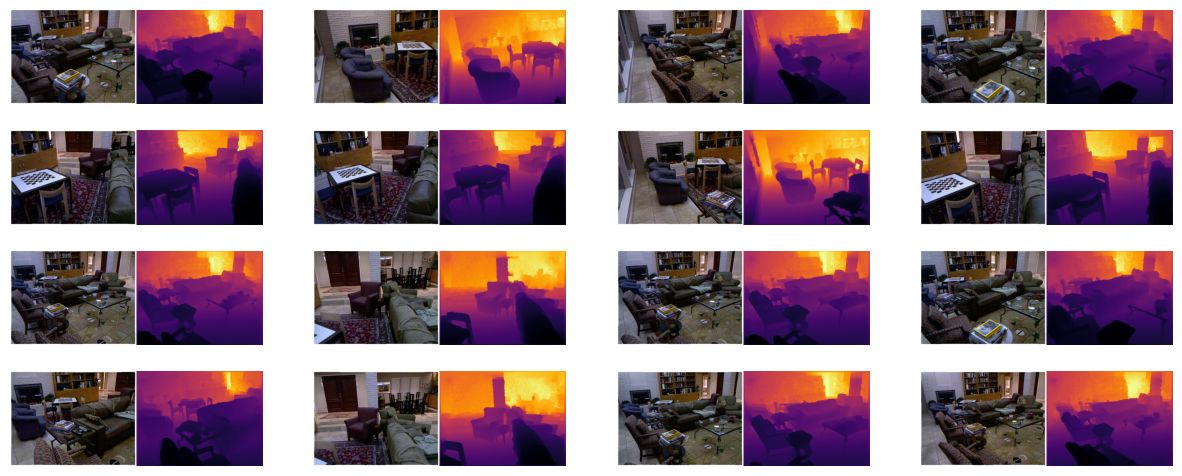

In [89]:
plt.figure(figsize=(15, 6))
selection = np.random.randint(0,len(df),(16,))

for i, idx in enumerate(range(16)):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(image,mask)
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [90]:
import albumentations as A

sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomResizedCrop(384,384),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]

train_tfms = A.Compose([
    *sample_tfms
])

valid_tfms = A.Compose([

])


In [91]:
import cv2 as cv

class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im

    def __len__(self,):
        return len(self.df)

    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        dp = dp.astype('float32')

        return im, dp

In [92]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, valid_tfms)
len(train_ds), len(val_ds), len(test_ds)

(4500, 450, 50)

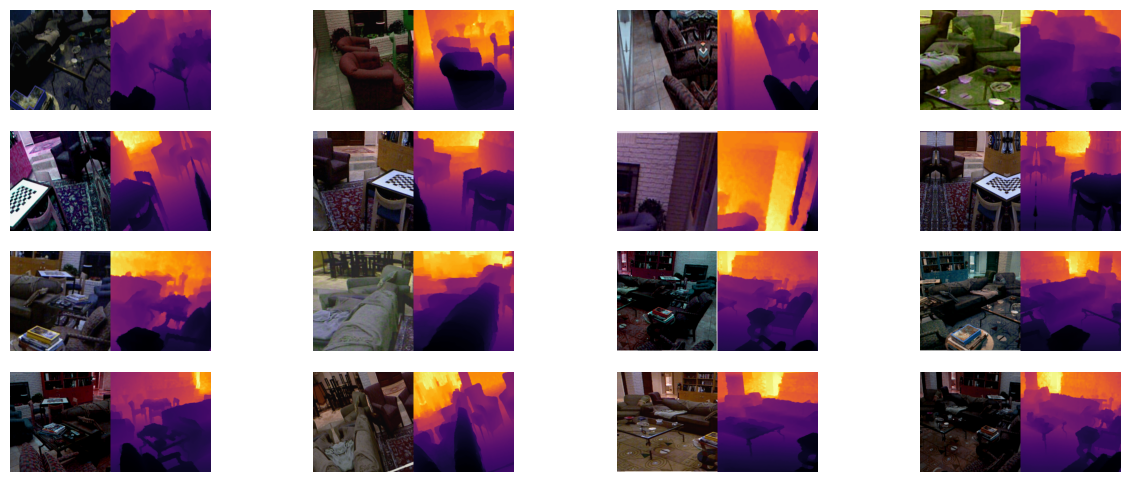

In [93]:
randoms = [train_ds[idx] for idx in range(16)]

plt.figure(figsize=(15, 6))
for i, (img,mask) in enumerate(randoms):
    ax = plt.subplot(4, 4, i + 1)
    mask = colored_depthmap(np.squeeze(mask))
    image_viz = np.hstack([img,mask])
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [94]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds,shuffle=True,batch_size=4)
val_dl = DataLoader(val_ds,shuffle=False,batch_size=4)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=1)
len(train_dl), len(val_dl), len(test_dl)

(1125, 113, 50)

In [95]:
for batch in train_dl:
    imgs, depths = batch
    print(f"Input shape: {imgs.shape}, Target shape: {depths.shape}")
    break

Input shape: torch.Size([4, 384, 384, 3]), Target shape: torch.Size([4, 384, 384])


In [96]:
inputs = processor.preprocess(imgs).to(device)
outputs = model(inputs)
preds = processor.postprocess(inputs, outputs)

print(inputs['pixel_values'].shape)
print(outputs.shape)
print(preds.shape)

torch.Size([4, 3, 1024, 1024])
torch.Size([4, 1, 256, 256])
torch.Size([4, 384, 384])


# Train

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt

In [99]:
class Trainer:
    def __init__(self, model, processor, data_loaders, criterion, optimizer, device=None):
        """
        Initialize the DepthEstimationTrainer.

        Args:
            model: PyTorch model to train.
            processor: Processor for data preprocessing and postprocessing.
            data_loaders: Tuple of DataLoaders for training, validation, and testing.
            criterion: Loss function for training and evaluation.
            optimizer: Optimizer for the model.
            device: Device for computation (default: auto-detect).
        """

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.processor = processor
        self.train_dl, self.val_dl, self.test_dl = data_loaders
        self.criterion = criterion
        self.optimizer = optimizer

        self.train_losses = []
        self.val_losses = []
        self.batch_losses = []

    def train_one_epoch(self):
        """Train the model for one epoch."""
        self.model.train()
        running_loss = 0.0

        for batch in tqdm(self.train_dl, desc="Training"):
            imgs, depths = batch
            depths = depths.to(self.device)

            self.optimizer.zero_grad()

            inputs = self.processor.preprocess(imgs).to(self.device)
            outputs = self.model(inputs)
            preds = self.processor.postprocess(inputs, outputs)

            loss = self.criterion(preds, depths)
            loss.backward()
            self.optimizer.step()

            self.batch_losses.append(loss.item())
            running_loss += loss.item()

        gc.collect()
        torch.cuda.empty_cache()

        return running_loss / len(self.train_dl)

    def evaluate(self, dataloader):
        """Evaluate the model."""
        self.model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluation"):
                imgs, depths = batch
                depths = depths.to(self.device)

                inputs = self.processor.preprocess(imgs).to(self.device)
                outputs = self.model(inputs)
                preds = self.processor.postprocess(inputs, outputs)

                loss = self.criterion(preds, depths)
                val_loss += loss.item()

        gc.collect()
        torch.cuda.empty_cache()

        return val_loss / len(dataloader)

    def abs_rel_difference(self, preds, depths):
        """Calculate Absolute Relative Difference (AbsRel)."""
        abs_rel = torch.mean(torch.abs(preds - depths) / depths)
        return abs_rel.item()

    def train(self, epochs):
        """Train the model for multiple epochs."""

        for epoch in range(epochs):
            train_loss = self.train_one_epoch()
            val_loss = self.evaluate(self.val_dl)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    def test(self):
        """Test the model on the test set."""
        self.model.eval()
        total = 0.0

        with torch.no_grad():
            for batch in self.test_dl:
                imgs, depths = batch
                depths = depths.to(self.device)

                inputs = self.processor.preprocess(imgs).to(self.device)
                outputs = self.model(inputs)
                preds = self.processor.postprocess(inputs, outputs)
                total += self.abs_rel_difference(preds, depths)

        gc.collect()
        torch.cuda.empty_cache()

        print(f"Test AbsRel: {total / len(self.test_dl):.4f}")

    def plot_learning_curve(self):
        """Final plot of the learning curve."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Learning Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    def visualize(self, num_samples=3):
        """Visualize predictions on the test set."""
        self.model.eval()
        return


In [100]:
criterion = nn.MSELoss()

learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [101]:
trainer = Trainer(model, processor, (train_dl, val_dl, test_dl), criterion, optimizer)

In [102]:
epochs = 1
trainer.train(epochs)

Evaluation: 100%|██████████| 113/113 [14:12<00:00,  7.55s/it]


Epoch 1/1, Train Loss: 0.0190, Val Loss: 0.0282


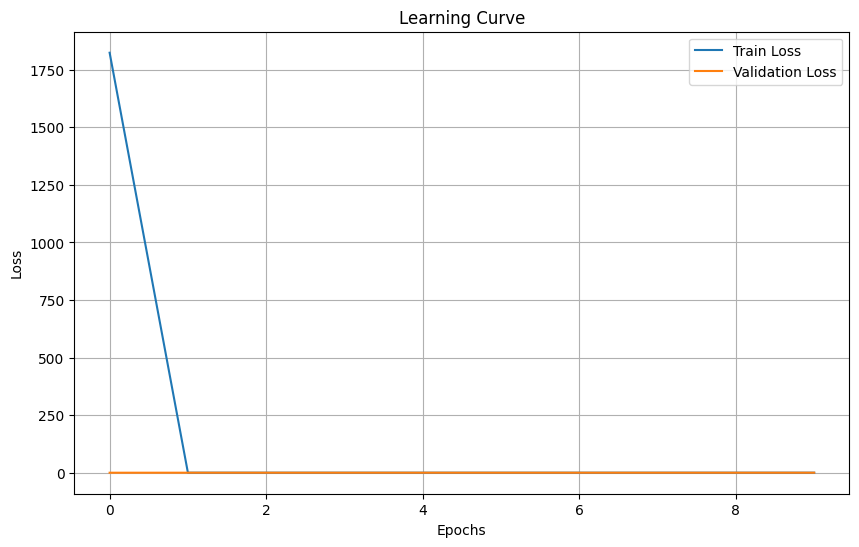

In [ ]:
trainer.plot_learning_curve()

In [103]:
save_path = base_path / "model/first.pth"
torch.save(model.state_dict(), save_path)

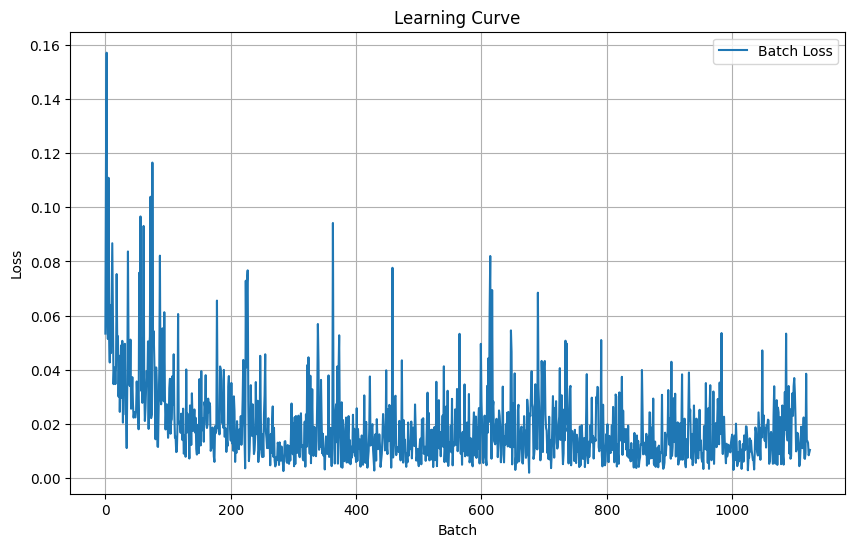

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(trainer.batch_losses, label='Batch Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

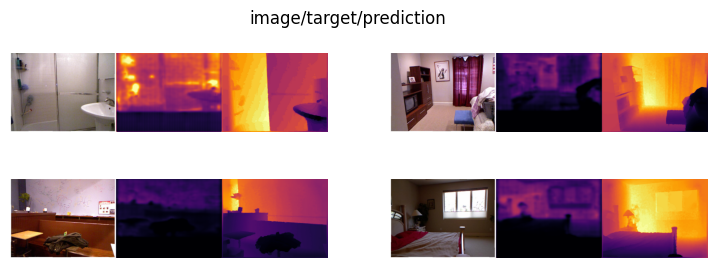

In [192]:
plt.figure(figsize=(9, 3))
r, c = 2, 2
selection = np.random.randint(0,len(val_ds),(4,))

with torch.no_grad():
    for i, idx in enumerate(selection):
        img, depth = val_ds[idx]

        input = processor.preprocess(img).to(device)
        outputs = model(input)
        pred = processor.postprocess(input, outputs)
        pred = pred.squeeze(0).cpu().numpy()

        d_min, d_max = np.min(depth), np.max(depth)
        depth = colored_depthmap(depth, d_min = d_min, d_max = d_max)
        pred = colored_depthmap(pred, d_min = d_min, d_max = d_max)

        image_viz = np.hstack([img, pred, depth])
        ax = plt.subplot(r, c, i + 1)
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")

    title = "image/target/prediction"
    plt.suptitle(title)
    plt.show()

In [193]:
load_path = base_path / "model/first.pth"
new_model = Network()
new_model.load_state_dict(torch.load(load_path))
new_model.eval()

<ipython-input-193-edd4e182591e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load(load_path))


Network(
  (sam): SamModel(
    (shared_image_embedding): SamPositionalEmbedding()
    (vision_encoder): SamVisionEncoder(
      (patch_embed): SamPatchEmbeddings(
        (projection): Conv2d(3, 168, kernel_size=(16, 16), stride=(16, 16))
      )
      (layers): ModuleList(
        (0-11): 12 x SamVisionLayer(
          (layer_norm1): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
          (attn): SamVisionAttention(
            (qkv): Linear(in_features=168, out_features=504, bias=True)
            (proj): Linear(in_features=168, out_features=168, bias=True)
          )
          (layer_norm2): LayerNorm((168,), eps=1e-06, elementwise_affine=True)
          (mlp): SamMLPBlock(
            (lin1): Linear(in_features=168, out_features=696, bias=True)
            (lin2): Linear(in_features=696, out_features=168, bias=True)
            (act): GELUActivation()
          )
        )
      )
      (neck): SamVisionNeck(
        (conv1): Conv2d(168, 256, kernel_size=(1, 1), stride=(1